In [41]:
%reload_ext autoreload
%autoreload 2
from scrape_GR_tools import *
from scrape_explore import *
#put this in scrape_GR_tools
import pandas as pd

import graphlab as gl

import networkx as nx
import nxpd as nxpd
import community

from datetime import date, datetime
grDateFormat = '%b %d, %Y'

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# setting up mongodb

client = MongoClient('mongodb://localhost:27017/')

db = client['goodreads_explore_multigraph']

friendsUnbiased = db['friends']
ratingsUnbiased = db['reviews']
booksUnbiased = db['books']

dbBiased = client['goodreads_explore_multigraph_biased_sampling']

friendsBiased = dbBiased['friends']
ratingsBiased = dbBiased['reviews']
booksBiased = dbBiased['books']

#dbFromBook = client['goodreads_explore_from_book']
dbFromBook = client['goodreads_explore_from_book_tunnel']

friendsFromBook = dbFromBook['friends']
ratingsFromBook = dbFromBook['reviews']
booksFromBook = dbFromBook['books']

dbSnowball = client['goodreads_snowball']
friendsSnowball = dbSnowball['friends']
ratingsSnowball = dbSnowball['reviews']
booksSnowball = dbSnowball['books']

In [4]:
def reset_colls(friends, ratings, books):
    friends.delete_many({})
    ratings.delete_many({})
    books.delete_many({})

In [5]:
checkBiased = False
checkFromBook = True
checkSnowball = False

In [8]:
focalBookID = 156182 # The Tunnel
#exploreFromBook(focalBookID, ratingsFromBook, friendsFromBook, booksFromBook, 0.05)

In [9]:
#nrID = 7607437
#searchIDs = snowballSample(ratingsSnowball, friendsSnowball, booksSnowball, nrID, 1, 0.05)

In [30]:
# checking what we've got

if checkBiased:
    friends = friendsBiased
    ratings = ratingsBiased
    books = booksBiased
elif checkFromBook:
    friends = friendsFromBook
    ratings = ratingsFromBook
    books = booksFromBook
elif checkSnowball:
    friends = friendsSnowball
    ratings = ratingsSnowball
    books = booksSnowball
else:
    friends = friendsUnbiased
    ratings = ratingsUnbiased
    books = booksUnbiased

t = books.find()
countList = []

for b in t:
    countList.append(len(b['ratings']))

clS = pd.Series(countList)
print '%d users' % ratings.count()
print '%d books' % books.count()
print '%d users have scraped friend lists\n' % friends.count()

print '%.2f%% of books have >1 ratings' % float(100*(clS>1).mean())
print '(%d books)\n' %(clS>1).sum()

print '%.2f%% of books have >2 ratings' % float(100*(clS>2).mean())
print '(%d books)\n' %(clS>2).sum()

print '%.2f%% of books have >5 ratings' % float(100*(clS>5).mean())
print '(%d books)\n' %(clS>5).sum()

print '%.2f%% of books have >10 ratings' % float(100*(clS>10).mean())
print '(%d books)\n' %(clS>10).sum()

print 'Descriptive statistics for ratings:'
clS.describe()

343 users
97656 books
346 users have scraped friend lists

23.64% of books have >1 ratings
(23085 books)

12.35% of books have >2 ratings
(12062 books)

4.65% of books have >5 ratings
(4539 books)

2.09% of books have >10 ratings
(2037 books)

Descriptive statistics for ratings:


count    97656.00000
mean         1.98679
std          4.75837
min          1.00000
25%          1.00000
50%          1.00000
75%          1.00000
max        286.00000
dtype: float64

In [258]:
nUserCounts = []
for i, row in enumerate(ratings.find()):
    nUserCounts.append(len(row['ratings']))
    
nBookCounts = []
bookIDlist = []
for i, row in enumerate(books.find()):
    nBookCounts.append(len(row['ratings']))
    bookIDlist.append(row['bookID'])

In [259]:
'''
for index in np.argsort(nBookCounts)[::-1][20:]:
    print (bookTitle(bookIDlist[index]),nBookCounts[index])
'''

'\nfor index in np.argsort(nBookCounts)[::-1][20:]:\n    print (bookTitle(bookIDlist[index]),nBookCounts[index])\n'

In [260]:
nUserCounts = pd.Series(nUserCounts)
print (nUserCounts < 10).mean()

nBookCounts = pd.Series(nBookCounts)
print (nBookCounts < 2).mean()

bookIDlist = pd.Series(bookIDlist)
booksToExclude = set(bookIDlist[nBookCounts < 10])
print (nBookCounts >= 10).sum()

0.0
0.821432455358
605


In [221]:
nBookCounts[nBookCounts>=10].describe()

count    478.000000
mean      17.248954
std        8.746053
min       10.000000
25%       11.000000
50%       14.000000
75%       20.000000
max       86.000000
dtype: float64

In [222]:
nUserCounts.describe()

count      105.000000
mean       624.942857
std       1358.742234
min         16.000000
25%        121.000000
50%        253.000000
75%        627.000000
max      12547.000000
dtype: float64

In [56]:
targetRatings = books.find_one({'bookID': focalBookID})['ratings']
targetRatingDates = np.array([datetime.strptime(r[2], grDateFormat) for r in targetRatings.values()])
#strictCutoff = min(targetRatingDates)
#print strictCutoff.strftime(grDateFormat)
print len(targetRatingDates)
print sum(targetRatingDates > datetime.strptime('Jan 1, 2014', grDateFormat)) / float(len(targetRatingDates))
cutoffDate = datetime.strptime('Jan 1, 2014', grDateFormat)
todayDate = date.today()
today = datetime(todayDate.year, todayDate.month, todayDate.day)

291
0.250859106529


In [261]:
glRatingDict = makeRatingDictForGL(ratings, booksToExclude)
glRatings = gl.SFrame(glRatingDict)

In [262]:
glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
                                                    user_id="userID", 
                                                    item_id="bookID")

In [263]:
nTrainObs = glRatingsTrain.shape[0]
nTrainUsers = len(glRatingsTrain['userID'].unique())
nTrainItems = len(glRatingsTrain['bookID'].unique())

print nTrainObs, nTrainUsers, nTrainItems

for n in range(1,6):
    print nTrainObs / (n*float(nTrainUsers + nTrainItems))

7954 118 605
11.0013831259
5.50069156293
3.66712770862
2.75034578147
2.20027662517


In [59]:
gl.recommender.util.random_split_by_user?

In [8]:
#cutoff date based

#glRatingDictTrain = makeRatingDictForGL(ratings, cutoffDate)
#glRatingsTrain = gl.SFrame(glRatingDictTrain)
#glRatingDictTest = makeRatingDictForGL(ratings, cutoffDate, upperBound=False)
#glRatingsTest = gl.SFrame(glRatingDictTest)

In [64]:
models = gl.toolkits.model_parameter_search.create((glRatingsTrain, glRatingsTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'userID',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': 0
                                                      })

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-17-2016-17-01-3100000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-17-2016-17-01-3100000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Nov-17-2016-17-01-3100000' already exists. Renaming the job to 'Model-Parameter-Search-Nov-17-2016-17-01-3100000-9015a'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-17-2016-17-01-3100000-9015a' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-17-2016-17-01-3100000-9015a' scheduled.


In [86]:
rec_engine_baseline = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=0,
                                                    solver='auto',
                                                    max_iterations=1000,
                                                    regularization = 0.001,
                                                    linear_regularization = 1e-5
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46371 observations with 323 users and 2649 items.

Data prepared in: 0.199116s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 0        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-12    |

| max_iterations                 | Maximum Number of Iterations                     | 1000     |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46371 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (2.52066 >= 0.912255)        |

| 1       | 6.25              | No Decrease (2.4945 >= 0.912255)         |

| 2       | 1.5625            | No Decrease (1.43365 >= 0.912255)        |

| 3       | 0.390625          | 0.641436                                 |

| 4       | 0.195312          | 0.544918                                 |

| 5       | 0.0976562         | 0.530009                                 |

| 6       | 0.0488281         | 0.552163                                 |

| 7       | 0.0244141         | 0.595269                                 |

| 8       | 0.012207          | 0.645926                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 0.530009                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 97us         | 0.895685          | 0.946406              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1.19s        | 0.825496          | 0.908566              | 0.0976562   |

| 2       | 2.34s        | 0.733602          | 0.856505              | 0.0580668   |

| 3       | 3.51s        | 0.701837          | 0.837757              | 0.042841    |

| 4       | 4.66s        | 0.687072          | 0.828898              | 0.0345267   |

| 5       | 5.83s        | 0.677245          | 0.822949              | 0.029206    |

| 6       | 7.05s        | 0.670455          | 0.818813              | 0.0254734   |

| 7       | 8.28s        | 0.665506          | 0.815786              | 0.0226922   |

| 8       | 9.47s        | 0.661278          | 0.81319               | 0.0205297   |

| 9       | 10.66s       | 0.657731          | 0.811006              | 0.018794    |

| 10      | 11.82s       | 0.656528          | 0.810264              | 0.017366    |

| 11      | 13.00s       | 0.65385           | 0.80861               | 0.016168    |

| 12      | 14.21s       | 0.652557          | 0.80781               | 0.0151466   |

| 13      | 15.38s       | 0.650411          | 0.806481              | 0.014264    |

| 14      | 16.54s       | 0.649038          | 0.805629              | 0.0134929   |

| 15      | 17.68s       | 0.647917          | 0.804933              | 0.0128124   |

| 16      | 18.90s       | 0.646968          | 0.804343              | 0.012207    |

| 17      | 20.11s       | 0.645939          | 0.803703              | 0.0116644   |

| 18      | 21.35s       | 0.645311          | 0.803312              | 0.011175    |

| 19      | 22.55s       | 0.644329          | 0.802701              | 0.0107309   |

| 20      | 23.70s       | 0.643528          | 0.802202              | 0.0103259   |

| 21      | 24.87s       | 0.642884          | 0.801801              | 0.00995487  |

| 22      | 26.05s       | 0.642421          | 0.801512              | 0.00961353  |

| 23      | 27.25s       | 0.641637          | 0.801022              | 0.00929831  |

| 24      | 28.45s       | 0.641063          | 0.800664              | 0.0090062   |

| 25      | 29.58s       | 0.640783          | 0.800489              | 0.00873464  |

| 26      | 30.74s       | 0.640026          | 0.800016              | 0.00848145  |

| 27      | 31.92s       | 0.640292          | 0.800182              | 0.00824474  |

| 28      | 33.14s       | 0.637075          | 0.79817               | 0.00674643  |

| 29      | 34.29s       | 0.634864          | 0.796784              | 0.00552569  |

| 30      | 35.41s       | 0.63309           | 0.79567               | 0.00452988  |

| 31      | 36.57s       | 0.633131          | 0.795696              | 0.00441984  |

| 32      | 37.79s       | 0.631326          | 0.79456               | 0.00362917  |

| 33      | 38.92s       | 0.629912          | 0.79367               | 0.00298213  |

| 34      | 40.06s       | 0.629023          | 0.79311               | 0.00245214  |

| 35      | 41.22s       | 0.628799          | 0.792968              | 0.00239941  |

| 36      | 42.35s       | 0.628682          | 0.792895              | 0.00234924  |

| 37      | 43.52s       | 0.628541          | 0.792806              | 0.00230146  |

| 38      | 44.71s       | 0.628553          | 0.792813              | 0.00225589  |

| 39      | 45.87s       | 0.627752          | 0.792308              | 0.00186037  |

| 40      | 47.07s       | 0.626987          | 0.791825              | 0.00153495  |

| 41      | 48.21s       | 0.626442          | 0.791481              | 0.00126705  |

| 42      | 49.32s       | 0.626348          | 0.791421              | 0.00124436  |

| 43      | 50.53s       | 0.626301          | 0.791392              | 0.00122259  |

| 44      | 51.71s       | 0.626271          | 0.791373              | 0.00120169  |

| 45      | 52.87s       | 0.626222          | 0.791342              | 0.00118161  |

| 46      | 54.00s       | 0.626153          | 0.791298              | 0.00116229  |

| 47      | 55.18s       | 0.626095          | 0.791262              | 0.00114369  |

| 48      | 56.32s       | 0.626071          | 0.791246              | 0.00112578  |

| 49      | 57.47s       | 0.626053          | 0.791235              | 0.0011085   |

| 50      | 58.60s       | 0.626003          | 0.791204              | 0.00109183  |

| 51      | 59.75s       | 0.62596           | 0.791176              | 0.00107573  |

| 52      | 1m 0s        | 0.625919          | 0.791151              | 0.00106018  |

| 53      | 1m 2s        | 0.625899          | 0.791138              | 0.00104514  |

| 54      | 1m 3s        | 0.625866          | 0.791117              | 0.00103059  |

| 55      | 1m 4s        | 0.625824          | 0.791091              | 0.00101651  |

| 56      | 1m 5s        | 0.625794          | 0.791071              | 0.00100286  |

| 57      | 1m 6s        | 0.625766          | 0.791054              | 0.000989638 |

| 58      | 1m 7s        | 0.625722          | 0.791026              | 0.000976813 |

| 59      | 1m 9s        | 0.625679          | 0.790999              | 0.00096437  |

| 60      | 1m 10s       | 0.625707          | 0.791016              | 0.00095229  |

| 61      | 1m 11s       | 0.625291          | 0.790753              | 0.000790911 |

| 62      | 1m 12s       | 0.625003          | 0.790571              | 0.000657013 |

| 63      | 1m 13s       | 0.624741          | 0.790406              | 0.000545889 |

| 64      | 1m 14s       | 0.624723          | 0.790394              | 0.00053948  |

| 65      | 1m 16s       | 0.624702          | 0.790381              | 0.000533243 |

| 66      | 1m 17s       | 0.624687          | 0.790372              | 0.000527172 |

| 67      | 1m 18s       | 0.624679          | 0.790367              | 0.000521259 |

| 68      | 1m 19s       | 0.624664          | 0.790357              | 0.0005155   |

| 69      | 1m 20s       | 0.624649          | 0.790348              | 0.000509886 |

| 70      | 1m 21s       | 0.624635          | 0.790339              | 0.000504413 |

| 71      | 1m 22s       | 0.624621          | 0.79033               | 0.000499076 |

| 72      | 1m 24s       | 0.624612          | 0.790324              | 0.000493868 |

| 73      | 1m 25s       | 0.624596          | 0.790314              | 0.000488785 |

| 74      | 1m 26s       | 0.624585          | 0.790307              | 0.000483823 |

| 75      | 1m 27s       | 0.624575          | 0.7903                | 0.000478976 |

| 76      | 1m 28s       | 0.62456           | 0.790291              | 0.000474242 |

| 77      | 1m 29s       | 0.624551          | 0.790286              | 0.000469615 |

| 78      | 1m 30s       | 0.624541          | 0.790279              | 0.000465092 |

| 79      | 1m 32s       | 0.624526          | 0.79027               | 0.00046067  |

| 80      | 1m 33s       | 0.624519          | 0.790265              | 0.000456344 |

| 81      | 1m 34s       | 0.624507          | 0.790257              | 0.000452112 |

| 82      | 1m 35s       | 0.624496          | 0.790251              | 0.000447971 |

| 83      | 1m 36s       | 0.62449           | 0.790247              | 0.000443917 |

| 84      | 1m 37s       | 0.62448           | 0.790241              | 0.000439947 |

| 85      | 1m 39s       | 0.624467          | 0.790232              | 0.00043606  |

| 86      | 1m 40s       | 0.624461          | 0.790228              | 0.000432251 |

| 87      | 1m 41s       | 0.624454          | 0.790224              | 0.00042852  |

| 88      | 1m 42s       | 0.624436          | 0.790213              | 0.000424862 |

| 89      | 1m 43s       | 0.624432          | 0.79021               | 0.000421277 |

| 90      | 1m 44s       | 0.624426          | 0.790206              | 0.000417761 |

| 91      | 1m 45s       | 0.624417          | 0.7902                | 0.000414313 |

| 92      | 1m 47s       | 0.624401          | 0.79019               | 0.000410931 |

| 93      | 1m 48s       | 0.624394          | 0.790186              | 0.000407613 |

| 94      | 1m 49s       | 0.624389          | 0.790183              | 0.000404356 |

| 95      | 1m 50s       | 0.624379          | 0.790176              | 0.00040116  |

| 96      | 1m 51s       | 0.62437           | 0.790171              | 0.000398022 |

| 97      | 1m 52s       | 0.62437           | 0.790171              | 0.00039494  |

| 98      | 1m 54s       | 0.624357          | 0.790162              | 0.000391914 |

| 99      | 1m 55s       | 0.624351          | 0.790159              | 0.000388941 |

| 100     | 1m 56s       | 0.624346          | 0.790156              | 0.00038602  |

| 101     | 1m 57s       | 0.624339          | 0.790151              | 0.00038315  |

| 102     | 1m 58s       | 0.624329          | 0.790145              | 0.000380329 |

| 103     | 1m 59s       | 0.624321          | 0.79014               | 0.000377557 |

| 104     | 2m 1s        | 0.624316          | 0.790137              | 0.000374831 |

| 105     | 2m 2s        | 0.624311          | 0.790133              | 0.00037215  |

| 106     | 2m 3s        | 0.624303          | 0.790128              | 0.000369514 |

| 107     | 2m 4s        | 0.624298          | 0.790125              | 0.000366921 |

| 108     | 2m 5s        | 0.624288          | 0.790119              | 0.00036437  |

| 109     | 2m 6s        | 0.624284          | 0.790117              | 0.00036186  |

| 110     | 2m 7s        | 0.624276          | 0.790111              | 0.00035939  |

| 111     | 2m 8s        | 0.624271          | 0.790108              | 0.000356959 |

| 112     | 2m 10s       | 0.624267          | 0.790106              | 0.000354566 |

| 113     | 2m 11s       | 0.624262          | 0.790103              | 0.00035221  |

| 114     | 2m 12s       | 0.624252          | 0.790096              | 0.00034989  |

| 115     | 2m 13s       | 0.62425           | 0.790095              | 0.000347606 |

| 116     | 2m 14s       | 0.624243          | 0.790091              | 0.000345356 |

| 117     | 2m 15s       | 0.624236          | 0.790086              | 0.000343139 |

| 118     | 2m 17s       | 0.62423           | 0.790083              | 0.000340956 |

| 119     | 2m 18s       | 0.624228          | 0.790081              | 0.000338805 |

| 120     | 2m 19s       | 0.624221          | 0.790077              | 0.000336685 |

| 121     | 2m 20s       | 0.624216          | 0.790073              | 0.000334596 |

| 122     | 2m 21s       | 0.624209          | 0.790069              | 0.000332537 |

| 123     | 2m 22s       | 0.624206          | 0.790067              | 0.000330507 |

| 124     | 2m 24s       | 0.624203          | 0.790065              | 0.000328506 |

| 125     | 2m 25s       | 0.624197          | 0.790061              | 0.000326533 |

| 126     | 2m 26s       | 0.624193          | 0.790059              | 0.000324588 |

| 127     | 2m 27s       | 0.624186          | 0.790054              | 0.000322669 |

| 128     | 2m 28s       | 0.624182          | 0.790052              | 0.000320777 |

| 129     | 2m 30s       | 0.624177          | 0.790049              | 0.00031891  |

| 130     | 2m 31s       | 0.624168          | 0.790043              | 0.000317068 |

| 131     | 2m 32s       | 0.624166          | 0.790042              | 0.000315251 |

| 132     | 2m 33s       | 0.624163          | 0.79004               | 0.000313458 |

| 133     | 2m 34s       | 0.624159          | 0.790037              | 0.000311689 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 0.623396

Final training RMSE: 0.789554

In [87]:
rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

Using default 16 lambda workers.

To maximize the degree of parallelism, add the following code to the beginning of the program:

"graphlab.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 64)"

Note that increasing the degree of parallelism also increases the memory footprint.

0.8426026494362266

In [91]:
rec_engine_1 = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=1,
                                                    solver='auto',
                                                    max_iterations=100,
                                                    regularization = 0.001,
                                                    linear_regularization = 1e-5
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46371 observations with 323 users and 2649 items.

Data prepared in: 0.168181s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 1        |

| regularization                 | L2 Regularization on Factors                     | 1        |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-12    |

| max_iterations                 | Maximum Number of Iterations                     | 100      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46371 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.00158772        | Not Viable                               |

| 1       | 0.00039693        | 0.885183                                 |

| 2       | 0.000198465       | 0.892168                                 |

| 3       | 9.92326e-05       | 0.895875                                 |

| 4       | 4.96163e-05       | 0.897879                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.00039693        | 0.885183                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 132us        | 0.895731          | 0.946414              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1.25s        | DIVERGED          | DIVERGED              | 0.00039693  |

| RESET   | 1.26s        | 0.895726          | 0.946412              |             |

| 1       | 2.45s        | DIVERGED          | DIVERGED              | 0.000198465 |

| RESET   | 2.46s        | 0.895739          | 0.946418              |             |

| 1       | 3.61s        | 0.888114          | 0.942398              | 9.92326e-05 |

| 2       | 4.83s        | 0.878951          | 0.937524              | 1.77153e-05 |

| 3       | 6.00s        | 0.876958          | 0.93646               | 9.7258e-06  |

| 4       | 7.19s        | 0.875789          | 0.935836              | 6.70285e-06 |

| 5       | 8.34s        | 0.874958          | 0.935392              | 5.11349e-06 |

| 6       | 9.49s        | 0.874313          | 0.935047              | 4.13339e-06 |

| 7       | 10.66s       | 0.873787          | 0.934766              | 3.46857e-06 |

| 8       | 11.79s       | 0.873342          | 0.934527              | 2.98798e-06 |

| 9       | 12.95s       | 0.872957          | 0.934322              | 2.62436e-06 |

| 10      | 14.10s       | 0.872618          | 0.93414               | 2.33964e-06 |

| 11      | 15.26s       | 0.872315          | 0.933978              | 2.11065e-06 |

| 12      | 16.38s       | 0.872041          | 0.933831              | 1.92249e-06 |

| 13      | 17.52s       | 0.871791          | 0.933698              | 1.76513e-06 |

| 14      | 18.70s       | 0.871562          | 0.933575              | 1.63159e-06 |

| 15      | 19.85s       | 0.87135           | 0.933461              | 1.51683e-06 |

| 16      | 21.03s       | 0.871152          | 0.933355              | 1.41715e-06 |

| 17      | 22.19s       | 0.870968          | 0.933257              | 1.32976e-06 |

| 18      | 23.36s       | 0.870795          | 0.933164              | 1.25253e-06 |

| 19      | 24.53s       | 0.870632          | 0.933077              | 1.18377e-06 |

| 20      | 25.69s       | 0.870478          | 0.932994              | 1.12218e-06 |

| 21      | 26.89s       | 0.870332          | 0.932916              | 1.06667e-06 |

| 22      | 28.03s       | 0.870194          | 0.932842              | 1.0164e-06  |

| 23      | 29.21s       | 0.870062          | 0.932771              | 9.70648e-07 |

| 24      | 30.37s       | 0.869936          | 0.932703              | 9.28841e-07 |

| 25      | 31.52s       | 0.869815          | 0.932639              | 8.90487e-07 |

| 26      | 32.68s       | 0.869699          | 0.932577              | 8.55174e-07 |

| 27      | 33.81s       | 0.869588          | 0.932517              | 8.22556e-07 |

| 28      | 34.97s       | 0.869482          | 0.93246               | 7.92334e-07 |

| 29      | 36.13s       | 0.869379          | 0.932405              | 7.64254e-07 |

| 30      | 37.37s       | 0.86928           | 0.932352              | 7.38097e-07 |

| 31      | 38.63s       | 0.869184          | 0.932301              | 7.1367e-07  |

| 32      | 39.79s       | 0.869092          | 0.932251              | 6.90809e-07 |

| 33      | 40.96s       | 0.869003          | 0.932203              | 6.69367e-07 |

| 34      | 42.14s       | 0.868916          | 0.932157              | 6.49216e-07 |

| 35      | 43.32s       | 0.868832          | 0.932112              | 6.30242e-07 |

| 36      | 44.48s       | 0.868751          | 0.932068              | 6.12346e-07 |

| 37      | 45.62s       | 0.868671          | 0.932025              | 5.95439e-07 |

| 38      | 46.79s       | 0.868594          | 0.931984              | 5.7944e-07  |

| 39      | 47.93s       | 0.86852           | 0.931944              | 5.64278e-07 |

| 40      | 49.10s       | 0.868447          | 0.931905              | 5.4989e-07  |

| 41      | 50.27s       | 0.868376          | 0.931867              | 5.36217e-07 |

| 42      | 51.50s       | 0.868307          | 0.93183               | 5.23207e-07 |

| 43      | 52.96s       | 0.868239          | 0.931794              | 5.10814e-07 |

| 44      | 54.15s       | 0.868174          | 0.931758              | 4.98994e-07 |

| 45      | 55.31s       | 0.868109          | 0.931724              | 4.87709e-07 |

| 46      | 56.47s       | 0.868046          | 0.93169               | 4.76923e-07 |

| 47      | 57.61s       | 0.867985          | 0.931657              | 4.66604e-07 |

| 48      | 58.78s       | 0.867925          | 0.931625              | 4.56722e-07 |

| 49      | 59.95s       | 0.867866          | 0.931593              | 4.4725e-07  |

| 50      | 1m 1s        | 0.867809          | 0.931563              | 4.38163e-07 |

| 51      | 1m 2s        | 0.867753          | 0.931532              | 4.29438e-07 |

| 52      | 1m 3s        | 0.867697          | 0.931503              | 4.21053e-07 |

| 53      | 1m 4s        | 0.867643          | 0.931474              | 4.12989e-07 |

| 54      | 1m 5s        | 0.86759           | 0.931445              | 4.05229e-07 |

| 55      | 1m 7s        | 0.867538          | 0.931417              | 3.97755e-07 |

| 56      | 1m 8s        | 0.867487          | 0.93139               | 3.90551e-07 |

| 57      | 1m 9s        | 0.867437          | 0.931363              | 3.83604e-07 |

| 58      | 1m 10s       | 0.867388          | 0.931337              | 3.769e-07   |

| 59      | 1m 11s       | 0.86734           | 0.931311              | 3.70426e-07 |

| 60      | 1m 12s       | 0.867292          | 0.931285              | 3.64171e-07 |

| 61      | 1m 14s       | 0.867246          | 0.93126               | 3.58123e-07 |

| 62      | 1m 15s       | 0.8672            | 0.931236              | 3.52273e-07 |

| 63      | 1m 16s       | 0.867155          | 0.931211              | 3.46611e-07 |

| 64      | 1m 17s       | 0.86711           | 0.931188              | 3.41128e-07 |

| 65      | 1m 18s       | 0.867067          | 0.931164              | 3.35816e-07 |

| 66      | 1m 19s       | 0.867024          | 0.931141              | 3.30667e-07 |

| 67      | 1m 21s       | 0.866982          | 0.931119              | 3.25673e-07 |

| 68      | 1m 22s       | 0.86694           | 0.931096              | 3.20828e-07 |

| 69      | 1m 23s       | 0.866899          | 0.931074              | 3.16125e-07 |

| 70      | 1m 24s       | 0.866859          | 0.931052              | 3.11558e-07 |

| 71      | 1m 25s       | 0.866819          | 0.931031              | 3.07121e-07 |

| 72      | 1m 26s       | 0.86678           | 0.93101               | 3.02808e-07 |

| 73      | 1m 28s       | 0.866741          | 0.930989              | 2.98615e-07 |

| 74      | 1m 29s       | 0.866703          | 0.930969              | 2.94537e-07 |

| 75      | 1m 30s       | 0.866666          | 0.930949              | 2.90568e-07 |

| 76      | 1m 31s       | 0.866629          | 0.930929              | 2.86705e-07 |

| 77      | 1m 32s       | 0.866592          | 0.930909              | 2.82944e-07 |

| 78      | 1m 33s       | 0.866556          | 0.93089               | 2.79279e-07 |

| 79      | 1m 35s       | 0.86652           | 0.930871              | 2.75709e-07 |

| 80      | 1m 36s       | 0.866485          | 0.930852              | 2.72228e-07 |

| 81      | 1m 37s       | 0.866451          | 0.930833              | 2.68835e-07 |

| 82      | 1m 38s       | 0.866416          | 0.930815              | 2.65525e-07 |

| 83      | 1m 39s       | 0.866383          | 0.930797              | 2.62295e-07 |

| 84      | 1m 40s       | 0.866349          | 0.930779              | 2.59143e-07 |

| 85      | 1m 41s       | 0.866316          | 0.930761              | 2.56066e-07 |

| 86      | 1m 43s       | 0.866284          | 0.930744              | 2.53061e-07 |

| 87      | 1m 44s       | 0.866252          | 0.930726              | 2.50126e-07 |

| 88      | 1m 45s       | 0.86622           | 0.930709              | 2.47258e-07 |

| 89      | 1m 46s       | 0.866188          | 0.930692              | 2.44455e-07 |

| 90      | 1m 47s       | 0.866157          | 0.930676              | 2.41715e-07 |

| 91      | 1m 48s       | 0.866127          | 0.930659              | 2.39036e-07 |

| 92      | 1m 50s       | 0.866096          | 0.930643              | 2.36416e-07 |

| 93      | 1m 51s       | 0.866066          | 0.930627              | 2.33852e-07 |

| 94      | 1m 52s       | 0.866037          | 0.930611              | 2.31343e-07 |

| 95      | 1m 53s       | 0.866007          | 0.930595              | 2.28888e-07 |

| 96      | 1m 54s       | 0.865978          | 0.93058               | 2.26484e-07 |

| 97      | 1m 56s       | 0.86595           | 0.930564              | 2.2413e-07  |

| 98      | 1m 57s       | 0.865921          | 0.930549              | 2.21825e-07 |

| 99      | 1m 58s       | 0.865893          | 0.930534              | 2.19566e-07 |

| 100     | 1m 59s       | 0.865865          | 0.930519              | 2.17353e-07 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.865851

Final training RMSE: 0.930511

In [89]:
print rec_engine_1.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']
print rec_engine_1.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

0.935480271011
0.0928776215748


In [90]:
rec_engine_8 = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=8,
                                                    solver='auto',
                                                    max_iterations=1000,                                                  max_iterations=1000,
                                                    regularization = 0.001,
                                                    linear_regularization = 1e-5
                                                    )

SyntaxError: keyword argument repeated (<ipython-input-90-2a5669fd64c7>, line 7)

In [ ]:
print rec_engine_8.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']
print rec_engine_8.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

In [33]:
rec_engine = rec_engine_8

bookWeightings = rec_engine.get('coefficients')['bookID']
npBookWeightings = bookWeightings['factors'].to_numpy()
for i, row in enumerate(npBookWeightings):
    npBookWeightings[i,:] /= np.linalg.norm(row)
bookWeightings['factors'] = gl.SArray(npBookWeightings)
bookWeightings = bookWeightings.unpack('factors')

In [52]:
bookWeightings.sort('factors.0', ascending=False)['factors.0'][50]

0.9777261449253141

In [55]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.0', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.0', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])

Flow My Tears, the Policeman Said
The Left Hand of Darkness
      
          (Hainish Cycle #6)
On Beauty
Dance Dance Dance
      
          (The Rat #4)
The Mote in God's Eye
      
          (Moties #1)
Labyrinths:  Selected Stories and Other Writings
------
Swann's Way
      
          (À la recherche du temps perdu #1)
Exodus


In [59]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.1', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.1', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])

The Taming of the Shrew
Mansfield Park
The Power and the Glory
------
To Say Nothing of the Dog
      
          (Oxford Time Travel #2)
A History of the World in 10½  Chapters


In [61]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.2', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 10])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.2', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 10])

Waiting
The War of the Worlds
The Sandman, Vol. 2: The Doll's House
      
          (The Sandman #2)
------



In [57]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.3', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.3', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])

Player Piano
The Snows of Kilimanjaro and Other Stories
------
The Time Traveler's Wife
The Silence of the Lambs
      
          (Hannibal Lecter #2)
Foundation's Edge
      
          (Foundation (Publication Order) #4)


In [58]:
print '\n'.join([bookTitle(int(bID)) for bID in bookWeightings.sort('factors.3', ascending=False)['bookID'][:5]])
print '------'
print '\n'.join([bookTitle(int(bID)) for bID in bookWeightings.sort('factors.3', ascending=True)['bookID'][:5]])

Casino Moon
Out on the Rim
      
          (Arthur Case Wu #2)
Outsider in Amsterdam
      
          (Amsterdam Cops Mysteries #1)
Dark Canyon
What's Not to Love?: The Adventures of a Mildly Perverted Young Writer
------
Hidden History: Exploring Our Secret Past
Among the Believers : An Islamic Journey
The Bottoms
American Scream
Fenwick Travers and the Years of Empire: An Entertainment


In [21]:
dfBookWeightings = bookWeightings.to_dataframe()

In [22]:
dfBookWeightings[dfBookWeightings['bookID']==str(focalBookID)]

,bookID,linear_terms,factors.0,factors.1,factors.2,factors.3
11,118154,0.154152,0.347579,0.171606,0.851917,0.352106


In [23]:
userWeightings = rec_engine.get('coefficients')['userID'].unpack('factors')

In [24]:
dfUserWeightings = userWeightings.to_dataframe()

In [62]:
dfUserWeightings[dfUserWeightings['userID']==7607437] #N.R.

,userID,linear_terms,factors.0,factors.1,factors.2,factors.3
7,7607437,0.759385,0.278522,-0.682661,0.481648,0.093921


In [235]:
targetTruth = glRatingsTest[glRatingsTest['bookID'] == str(focalBookID)]

(15, 3)

In [61]:
targetPreds = barthTruth['userID','rating'].add_column(rec_engine.predict(targetTruth), name="modelRating")

NameError: name 'rec_engine' is not defined

In [366]:
evalTarget = rec_engine.evaluate_rmse(targetTruth, target='rating')
print evalTarget['rmse_overall']
print evalTarget['rmse_overall'] - eval['rmse_overall']

0.888040534664
-0.0348179848496


In [11]:
allFriendIDs = reduce(lambda l1, l2: l1+l2, [f['friends'] for f in friends.find()])

In [12]:
len(allFriendIDs) - len(set(allFriendIDs))

7651

In [22]:
friendCounts = []
userIDlist = []

for f in friends.find():
    userIDlist.append(f['userID'])
    
userIDset = set(userIDlist)

for f in friends.find():
    friendCounts.append(len(set(f['friends']) & userIDset))

In [14]:
friendCounts = pd.Series(friendCounts)
friendCounts.describe()

count    323.000000
mean       1.566563
std        4.490611
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       31.000000
dtype: float64

In [15]:
(friendCounts > 0).sum()

79

In [16]:
df = pd.DataFrame([userIDlist, list(friendCounts)]).T
friendLocs = df.iloc[:,0][df.iloc[:,1]>0]

In [268]:
fullTargetTruth = glRatings[glRatings['bookID'] == str(focalBookID)]
fullTargetTruthDf = fullTargetTruth.to_dataframe()
fullTargetTruthDf.set_index('userID',inplace=True)
fullTargetTruthDf['rating'].describe()

count    96.000000
mean      3.916667
std       1.166792
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000
Name: rating, dtype: float64

In [269]:
fullTargetTruthDf.loc[friendLocs,:]

,bookID,rating
userID,,
5960716,NaN,NaN
5163439,156182,4.0
13368360,156182,3.0
10074154,156182,4.0
6214700,NaN,NaN
5022264,156182,4.0
20612160,156182,5.0
5484622,156182,5.0
7324260,156182,5.0


In [39]:
adj_dict = {}
for f in friends.find():
    curFlist = set(f['friends'])
    friendsInData = curFlist & set(userIDlist)
    if len(friendsInData) > 0:
        adj_dict[f['userID']] = list(friendsInData)

In [40]:
len(adj_dict)

85

In [43]:
g = nx.from_dict_of_lists(adj_dict)

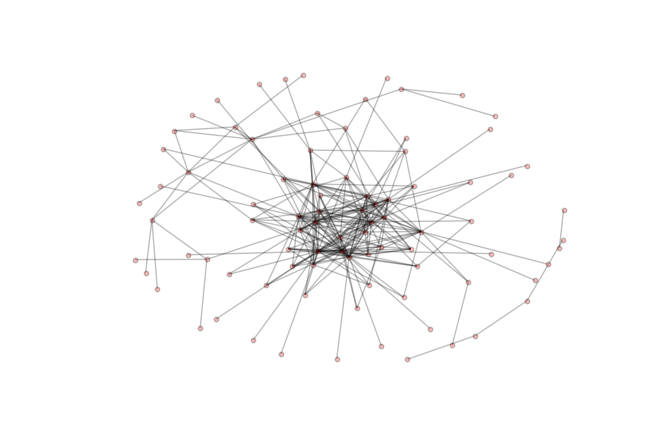

In [44]:
nx.draw(g, node_size=10, alpha=0.25)

In [74]:
commDict = community.best_partition(g)
commDict = {k: v+1 for k, v in commDict.items()}

In [75]:
g.graph['overlap']='scale'

nx.set_node_attributes(g, 'color', commDict)
nx.set_node_attributes(g, 'colorscheme', 'paired12')
nx.set_node_attributes(g, 'style', 'filled')

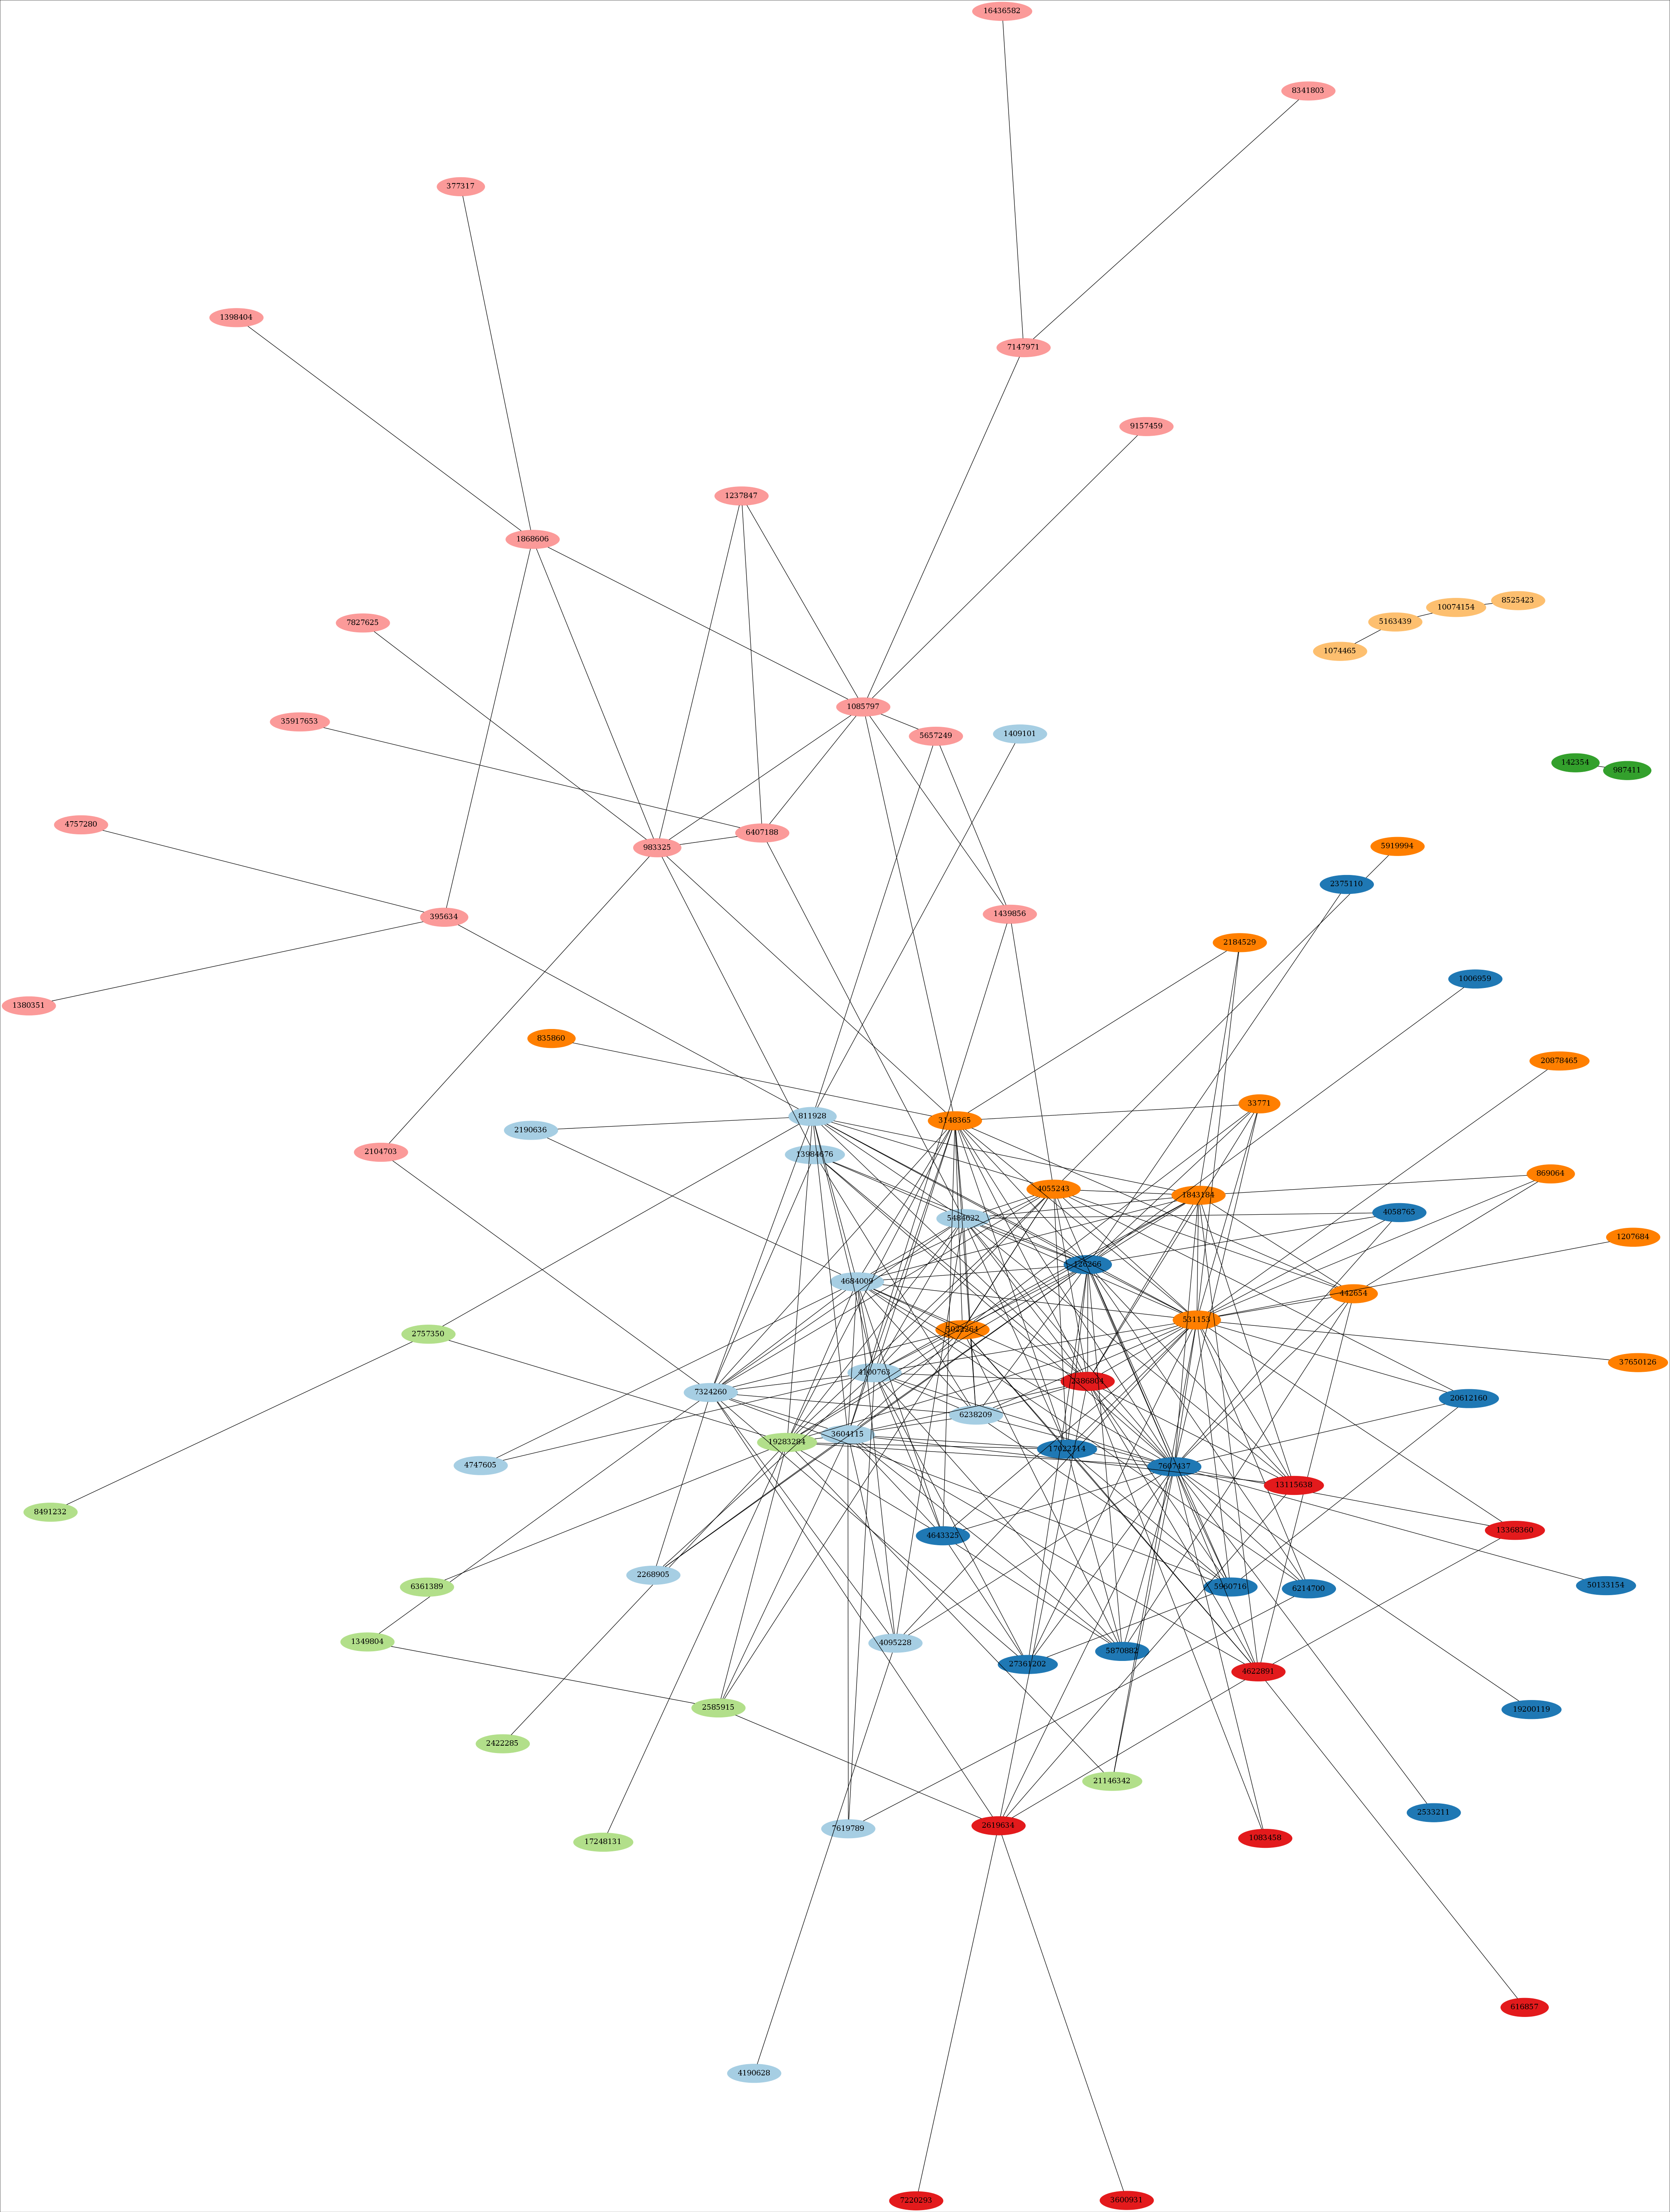

In [76]:
nxpd.draw(g, layout='neato', show='ipynb')